<center><h1>StreamSoNG (Streaming Soft Neural Gas)</h1></center>

<hr />

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from streamsong.algorithms import NeuralGas, PKNN, SP1M, StreamSoNG

In [2]:
X1 = np.random.normal(-2, 2,(100, 2))
Y1 = np.zeros(len(X1))
X2 = np.random.normal(15, 4,(100, 2))
Y2 = np.zeros(len(X2)) + 1
X = np.concatenate((X1, X2), axis=0)
Y = np.concatenate((Y1, Y2), axis=0)

X.shape, Y.shape

((200, 2), (200,))

In [3]:
C = len(np.unique(Y))
"C", C

('C', 2)

# Neural Gas (NG)

In [4]:
num_prototypes = 5
dimension = 2
prototypes = []
prototype_labels = []

for c in range(C):
    indices = np.where(Y == c)
    X_c = X[indices]
    Y_c = Y[indices]
    ng = NeuralGas(num_prototypes=num_prototypes, dimension=dimension, step_size=0.01, neighborhood_range=2)
    ng.initialize_prototypes(X_c, Y_c)
    for epoch in range(20):
        ng.learn(X)
    prototypes.extend(ng.prototypes)
    prototype_labels.extend(ng.prototype_labels)

prototypes = np.array(prototypes)
prototype_labels = np.array(prototype_labels)
print(prototypes.shape, prototype_labels.shape)

(10, 2) (10,)


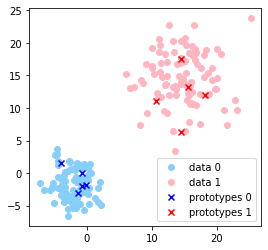

In [5]:
data_colors = ("lightskyblue", "lightpink")
prototype_colors = ("blue", "red")

fig, ax = plt.subplots()

# data
for c in range(C):
    indices = np.where(Y == c)
    X_c = X[indices]
    Y_c = Y[indices]
    ax.scatter(X_c[:, 0], X_c[:, 1], label=f"data {c}", color=data_colors[c])
    
# prototypes
for c in range(C):
    indices = np.where(prototype_labels == c)
    prototypes_c = prototypes[indices]
    ax.scatter(prototypes_c[:, 0], prototypes_c[:, 1], c=prototype_colors[c], label=f"prototypes {c}", marker="x")

ax.set_aspect(1)
plt.legend()
plt.show()

In [6]:
prototypes.shape

(10, 2)

# Probabilistic K-Nearest Neighbors (PKNN)

In [7]:
pknn = PKNN(prototypes=prototypes, prototype_labels=prototype_labels, num_classes=C, K=3, fuzzifier=1.5)

# SP1M

In [8]:
sp1m_test = SP1M(C=2, fuzzifier=2, bandwidth=np.sqrt(2))
U, V = sp1m_test.process(X)
print("V", V)
print("U", np.array(U).shape)

V [array([ 7.15084335, 13.31623598]), array([13.53159601, 19.78388758])]
U (2, 200)


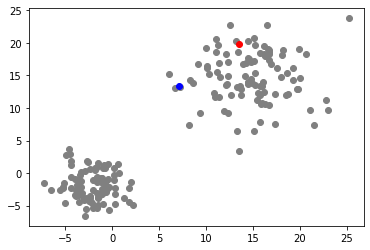

In [9]:
data_colors = ("lightskyblue", "lightpink")
prototype_colors = ("blue", "red")

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], color="gray")
for i, v in enumerate(V):
    ax.scatter(v[0], v[1], color=prototype_colors[i])

In [10]:
sp1m = SP1M(C=1, fuzzifier=2, bandwidth=np.sqrt(2))

# StreamSoNG

In [11]:
streamsong = StreamSoNG(ng=ng, pknn=pknn, sp1m=sp1m, typicality_threshold=0.2, learning_rate=0.5, neighborhood_range=2, num_points_for_new_class=10)

# Run

array([2.83903081, 5.19175688])

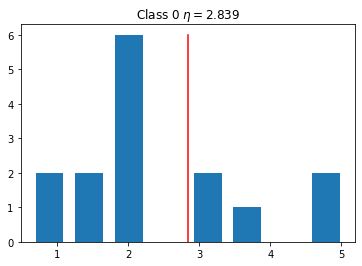

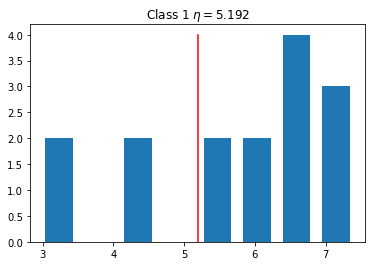

In [12]:
streamsong.pknn.estimate_radius(n=3, show_figure=True)
streamsong.pknn.radius

In [13]:
X_all = X.copy()
Y_all = Y.copy()

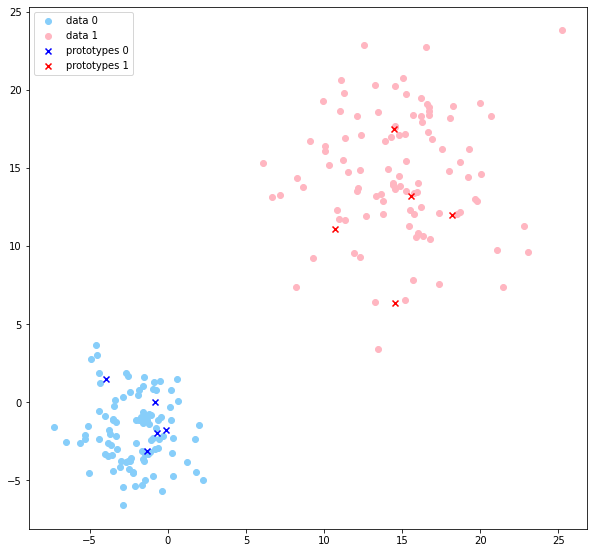

In [14]:
streamsong.visualize(X_all, Y_all)

In [15]:
X_new = np.random.normal((12, 12), 2, (100, 2))
Y_new = np.zeros(len(X_new)) + streamsong.pknn.num_classes

X_all = np.concatenate((X_all, X_new))
Y_all = np.concatenate((Y_all, Y_new))
print(len(X_all))

300


In [16]:
streamsong.stream_process(X_new, Y_new)

> NEW CLASS from 11 points


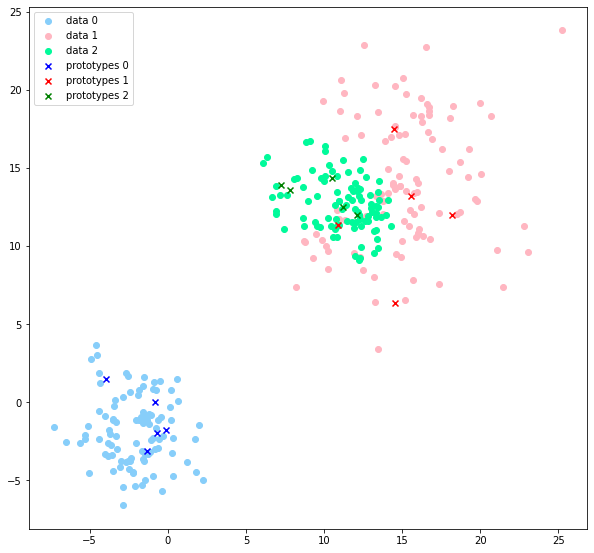

In [17]:
streamsong.visualize(X_all, Y_all)

In [18]:
X_new = np.random.normal((5, 10), 2, (100, 2))
Y_new = np.zeros(len(X_new)) + streamsong.pknn.num_classes

X_all = np.concatenate((X_all, X_new))
Y_all = np.concatenate((Y_all, Y_new))
print(len(X_all))

400


In [19]:
streamsong.stream_process(X_new, Y_new)

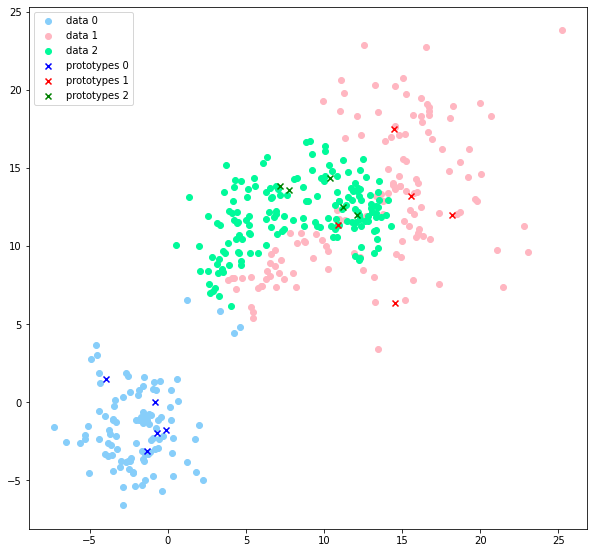

In [20]:
streamsong.visualize(X_all, Y_all)

In [21]:
X_new = np.random.normal((20, 0), 1, (100, 2))
Y_new = np.zeros(len(X_new)) + streamsong.pknn.num_classes

X_all = np.concatenate((X_all, X_new))
Y_all = np.concatenate((Y_all, Y_new))
print(len(X_all))

500


In [22]:
streamsong.stream_process(X_new, Y_new)

> NEW CLASS from 11 points


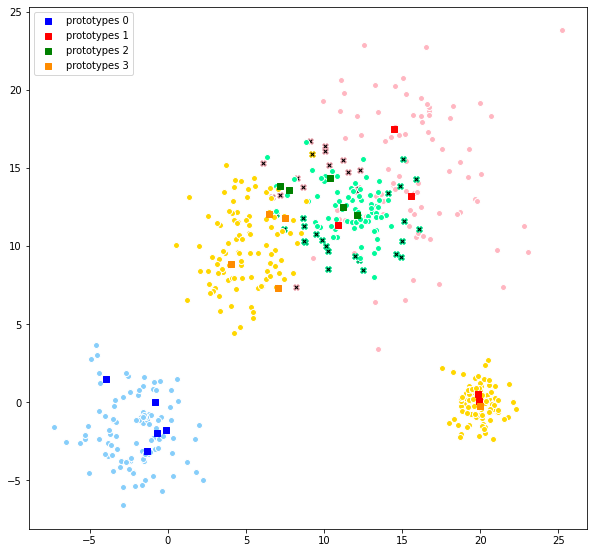

In [23]:
streamsong.visualize_prediction(X_all, Y_all)